In [1]:
!pip install -r requirements.txt

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import constants
from scipy import signal
import scipy.integrate as integrate
import scipy.special as special
from scipy.integrate import dblquad
from matplotlib.ticker import MultipleLocator
import pylab
import astropy.units as u
from astropy.constants import G, c
from astropy.cosmology import FlatLambdaCDM, z_at_value
from scipy.special import gamma as gamma_func
from matplotlib.colors import LogNorm

In [4]:
from pycbc.waveform import get_td_waveform, get_fd_waveform
from pycbc.waveform import td_approximants, fd_approximants
import pycbc.waveform
from pycbc.types import TimeSeries
from pycbc.types import FrequencySeries
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.psd import interpolate, inverse_spectrum_truncation
import pylab
from pycbc.filter import resample_to_delta_t, highpass
import pycbc.noise
import pycbc.psd
from pycbc.filter import matched_filter
from pycbc.filter import sigma
from mpmath import mp
from astropy.cosmology import Planck18 as cosmo
from matplotlib.ticker import LogLocator, LogFormatter
from pycbc.psd import welch

/home/rosar/phd/personal/phd/lib/python3.12/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal
PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1
/home/rosar/phd/personal/phd/lib/python3.12/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrai

In [5]:
from functools import partial
import multiprocessing
from tqdm import tqdm
from multiprocessing import cpu_count

ncpu = cpu_count()
print(f"{ncpu} CPUs")

20 CPUs


## MCMC in wave optic regime

In [6]:
solar_mass_kg = 1.9891e30

In [7]:
def calculate_amplification_factor(f_gw, M_kg, dl_m, beta_rad, einstein_rad_rad):
    """
    Calculates the complex wave optics amplification factor F(f).
    """
    # Create an output array for the results, initialized to handle f=0
    # At f=0, there is no wave, so magnification is 1
    F_f = np.ones_like(f_gw, dtype=complex)

    # Identify where the frequency is non-zero to avoid log(0) errors
    non_zero_freq_mask = f_gw > 0

    # Only perform calculations on the non-zero frequencies
    f_calc = f_gw[non_zero_freq_mask]

    if dl_m < (100*u.pc).to(u.m).value:
      z_l = 0
    else:
      z_l = z_at_value(cosmo.angular_diameter_distance,dl_m*(u.m), zmax = 1.6) #Planck18 cosmology

    # Redshifted mass of the lens
    Mz_kg = M_kg * (1 + z_l)

    # Calculate dimensionless parameters y(f) and w(beta)
    y = (8 * np.pi * G.value * Mz_kg / (c.value**3)) * f_calc
    w = beta_rad / einstein_rad_rad
    # Calculate the phi_m phase term
    xm = (w + np.sqrt(w**2 + 4)) / 2
    phi_m = (xm - w)**2 / 2 - np.log(xm)

    # Arguments for the special functions
    gamma_arg = 1 - 1j * y / 2
    hyp1f1_a = 1j * y / 2
    hyp1f1_z = 1j * (w**2) * y / 2

    #F_f equation implementation

    term1 = np.exp((np.pi * y / 4) + (1j * y / 2) * (np.log(y / 2) - 2*phi_m))
    term2 = gamma_func(gamma_arg)
    term3 = np.zeros_like(hyp1f1_a, dtype=complex)

    for i in range(len(hyp1f1_a)):
        a_real = float(hyp1f1_a[i].real)
        a_imag = float(hyp1f1_a[i].imag)
        z_real = float(hyp1f1_z[i].real)
        z_imag = float(hyp1f1_z[i].imag)

        # Create mpmath complex numbers correctly
        a_mp = mp.mpc(a_real, a_imag)
        z_mp = mp.mpc(z_real, z_imag)

        term3[i] = complex(mp.hyp1f1(a_mp, 1, z_mp))

    # Place the calculated results into the correct positions in the output array
    F_f[non_zero_freq_mask] = term1 * term2 * term3

    return F_f

In [8]:
def einstein_radius_calc(M_kg, ds_m, dl_m):
    if ds_m <= dl_m: return 0
    d_ls_m = ds_m - dl_m
    einstein_rad_sq = (4 * G.value * M_kg / (c.value**2)) * (d_ls_m / (ds_m * dl_m))
    return np.sqrt(einstein_rad_sq)

In [17]:
def calculate_SNR_for_point(params, fixed_mass_kg, fixed_ds_m, hp_unlensed_freq_template, data_freq, new_psd):

    dl_pc, beta_arcsec = params
    dl_m = (dl_pc * u.pc).to(u.m).value

    if dl_m >= fixed_ds_m:  # Lens cannot be beyond source
        return np.nan

    beta_rad = (beta_arcsec * u.arcsec).to(u.rad).value
    e_rad = einstein_radius_calc(fixed_mass_kg, fixed_ds_m, dl_m)
    frequency_array = np.asarray(hp_unlensed_freq_template.sample_frequencies)

    if e_rad > 0:
        try:

            # Calculate the template amplification factor
            F_f_template = calculate_amplification_factor(frequency_array,
                                                         fixed_mass_kg, dl_m,
                                                         beta_rad, e_rad)

            # Create the ALIGNED lensed template waveform in the frequency domain
            h_lensed_template_freq = hp_unlensed_freq_template * F_f_template

            #data_timeseries = data_freq.to_timeseries()
            #start_d = float(data_timeseries.start_time)
            #s_d = int(-start_d*4096)+1
            #max_time_data = data_timeseries.sample_times[s_d]

            #template_timeseries = h_lensed_template_freq.to_timeseries()
            #start = float(template_timeseries.start_time)
            #s = int(-start*4096)+1
            #max_time_template = template_timeseries.sample_times[s]

            #time_shift = max_time_data - max_time_template
            #h_lensed_template = h_lensed_template_freq.cyclic_time_shift(time_shift)



            # Ensure frequency series are compatible for subtraction
            '''
            h_lensed_template = FrequencySeries(
                    h_lensed_template.data,
                    delta_f=data_freq.delta_f,  # Force same delta_f
                    epoch=hp_unlensed_freq_template.epoch
                )
            

            snr_series = matched_filter(
                h_lensed_template,
                data_freq,
                psd=new_psd,
                low_frequency_cutoff=20,
                high_frequency_cutoff=1024
            )
            '''
            snr_series = matched_filter(
                h_lensed_template_freq,
                data_freq,
                psd=new_psd,
                low_frequency_cutoff=20,
                high_frequency_cutoff=1024
            )

            #snr_times = snr_series.sample_times.numpy()
            #time_window = 0.1  # seconds
            #window_mask = np.abs(snr_times) < time_window
            snr_array = abs(np.asarray(snr_series))
            #snr_in_window = np.abs(snr_series.data[window_mask])
            #if len(snr_in_window) == 0:
            #    return np.nan
            #max_snr_in_window = np.max(snr_in_window)
            max_snr = float(np.max(snr_array))

            #return max_snr_in_window
            return max_snr

        except Exception as e:
            #errors
            print(f"Error at dl={dl_pc}, beta={beta_arcsec}: {e}")
            return np.nan

    else:
        return np.nan


In [14]:
hp_unlensed,_ = get_td_waveform(approximant='SEOBNRv3',
                             mass1=30,
                             mass2=30,
                             delta_t=1.0/4096,
                             f_lower=20,
                             distance = 300
                            )
hp_unlensed.to_frequencyseries().delta_f

1.0111083683041224


Optimal SNR of the injected signal: 182.10

Simulated data created

Calculating SNR for 400 grid points...


100%|██████████| 400/400 [00:38<00:00, 10.44it/s]


Calculation complete.

Max SNR value found: 176.294736
Found 1 promising parameter combinations.

These parameter sets can now be used to initialize MCMC walkers:

Top best parameter combinations:
  1. dl = 12700.00 pc, beta = 2.00e-04 arcsec, chi² = 176.294736

Best point to start MCMC:
  dl   = 12700.00 pc
  beta = 2.00e-04 arcsec
  ds   = 300 Mpc (fixed)
  M    = 45 M_sun (fixed)
  chi² = 176.294736


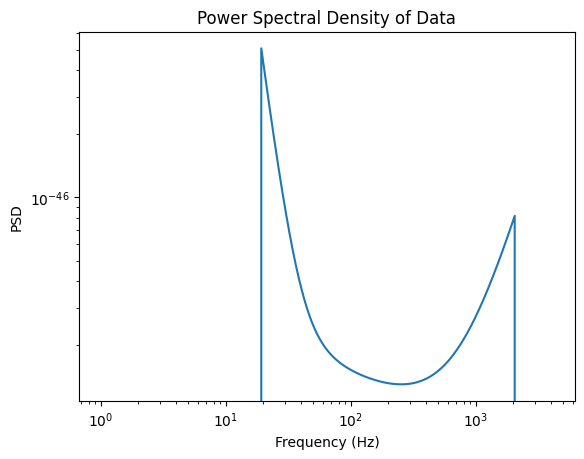

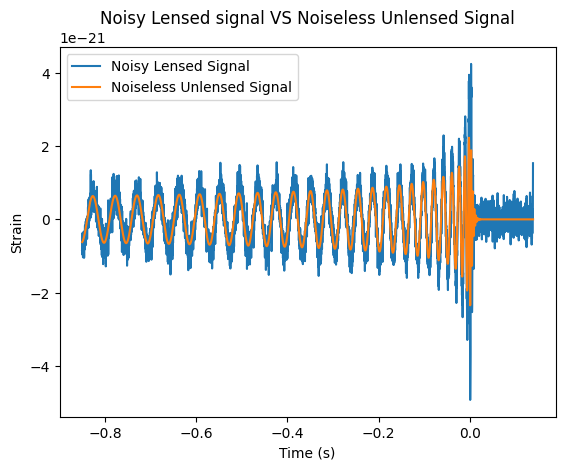

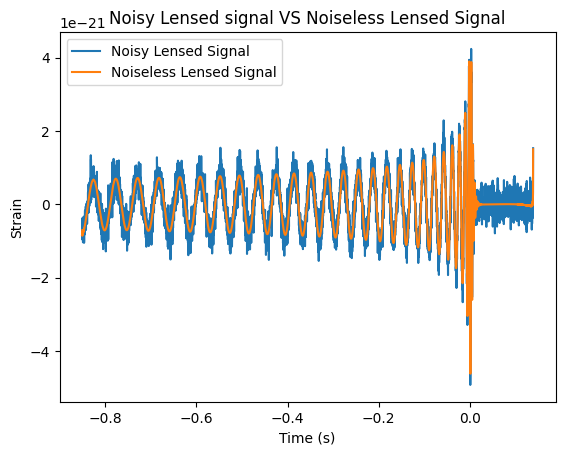

In [ ]:
if __name__ == "__main__":

    #----First, we create our lensed data

    true_mass_lens = 45 #solar_masses
    true_dl_pc = 12897 #pc
    true_ds_pc = 300 #Mpc
    true_beta_arcsec = 2.5e-4

    hp_unlensed,_ = get_td_waveform(approximant='SEOBNRv3',
                             mass1=30,
                             mass2=30,
                             delta_t=1.0/4096,
                             f_lower=20,
                             distance = true_ds_pc)


    #Calculate the amplification in the wave optic regime
    true_mass_lens_kg = true_mass_lens*solar_mass_kg #kg
    true_dl_m = (12897*u.pc).to(u.m).value #m
    true_ds_m = (300e6*u.pc).to(u.m).value #m
    true_beta_rad = (2.5e-4*u.arcsec).to(u.rad).value #rad

    hp_unlensed_freq = hp_unlensed.to_frequencyseries()
    frequency_array_template = np.asarray(hp_unlensed_freq.sample_frequencies)
    true_einstein_rad = einstein_radius_calc(true_mass_lens_kg,true_ds_m,true_dl_m)
    true_F_f = calculate_amplification_factor(frequency_array_template,true_mass_lens_kg,true_dl_m,true_beta_rad,true_einstein_rad)

    #Apply the magnification
    hp_lensed_freq = hp_unlensed_freq * true_F_f
    hp_lensed = hp_lensed_freq.to_timeseries()
    hp_lensed = resample_to_delta_t(highpass(hp_lensed,10),1./4096)  #Warning, this induce artifacts at end end begininng but I don't think it is problematic as we'll focus at merger time
    hp_lensed.crop(0.1,0.1)

    # 4. Generate realistic noise
    delta_f = 1/hp_lensed.duration
    flen = len(hp_lensed)//2 + 1
    f_low = 20
    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    delta_t = 1.0 / 4096
    noise_len = len(hp_lensed)
    noise = pycbc.noise.noise_from_psd(noise_len, delta_t, psd, seed=150)
    noise_timeseries = TimeSeries(noise, delta_t= delta_t, epoch = hp_lensed.start_time) #bruit plotté à partir de t = 0 -> need a shift in h_plus
    

    #Inject noise into the lensed signal. This is our data & its psd
    data = hp_lensed + noise_timeseries
    psd_data = interpolate(psd,data.delta_f)
    psd_data.resize(len(data))


    pylab.figure()
    pylab.loglog(psd_data.sample_frequencies,psd_data)
    pylab.xlabel('Frequency (Hz)')
    pylab.ylabel('PSD')
    pylab.title('Power Spectral Density of Data')
    pylab.figure()
    pylab.plot(data.sample_times,data, label = "Noisy Lensed Signal")
    pylab.plot(hp_unlensed.sample_times,hp_unlensed, label = "Noiseless Unlensed Signal")
    pylab.xlabel('Time (s)')
    pylab.ylabel('Strain')
    pylab.legend()
    pylab.title('Noisy Lensed signal VS Noiseless Unlensed Signal')
    pylab.figure()
    pylab.plot(data.sample_times,data, label = "Noisy Lensed Signal")
    pylab.plot(hp_lensed.sample_times,hp_lensed, label = "Noiseless Lensed Signal")
    pylab.xlabel('Time (s)')
    pylab.ylabel('Strain')
    pylab.legend()
    pylab.title('Noisy Lensed signal VS Noiseless Lensed Signal')




    #delta_f = hp_lensed_freq.delta_f

    snr_series_best = matched_filter(data,data,psd=psd_data,low_frequency_cutoff=20,high_frequency_cutoff=1024)
    snr_array_best = np.asarray(snr_series_best)

    max_snr_best = np.max(np.abs(snr_array_best))

    print(f"\nOptimal SNR of the injected signal: {max_snr_best:.2f}\n")

    print ("Simulated data created\n")
    #---------------------------

    #Fixed parameters
    fixed_ds_pc = true_ds_pc*1e6 # Source distance in Mpc
    fixed_lens_mass = true_mass_lens # Lens mass in Solar Masses
    fixed_ds_m = (true_ds_pc * 1e6 * u.pc).to(u.m).value
    fixed_mass_kg = true_mass_lens * solar_mass_kg



    #Preparation of the template
    hp_unlensed_template = hp_unlensed.copy()
    hp_unlensed_template.resize(len(data))
    hp_unlensed_freq_template = hp_unlensed_template.to_frequencyseries()
    data_freq = data.to_frequencyseries()

    '''
    hp_unlensed_freq_template = FrequencySeries(
        hp_unlensed_freq_template.data,
        delta_f=data_freq.delta_f,  # Force same delta_f for divison between frequency_series
        epoch=hp_unlensed_freq_template.epoch)
    '''

    #--- SETUP THE 2D SLICE ANALYSIS 

    #Create the 2D grid for the parameters we want to vary
    n_points = 20
    dl_pc_range = np.linspace(12700, 13000, n_points)
    beta_arcsec_range = np.linspace(2e-4, 3e-4, n_points) 



    dl_grid, beta_grid = np.meshgrid(dl_pc_range, beta_arcsec_range, indexing='ij')



    #Multiprocessing 
    print(f"Calculating SNR for {n_points*n_points} grid points...")

    params_list = list(zip(dl_grid.flatten(), beta_grid.flatten()))

    worker_func = partial(calculate_SNR_for_point,
                          fixed_mass_kg=fixed_mass_kg,
                          fixed_ds_m=fixed_ds_m,
                          hp_unlensed_freq_template=hp_unlensed_freq_template,
                          data_freq=data_freq,
                          #data=data,
                          new_psd=psd_data)
    

    #with multiprocessing.Pool(processes=18) as pool:
     #   results = list(tqdm(pool.imap(worker_func, params_list), total=len(params_list)))
    
    results = []
    for params in tqdm(params_list):
        result = worker_func(params)
        results.append(result)
    
    results = np.array(results)
    max_snr_grid = results.reshape(dl_grid.shape)
    print("Calculation complete.\n")

    # ---FILTER RESULTS TO FIND PROMISING PARAMETERS 

    max_snr = np.nanmax(max_snr_grid)
    print(f"Max SNR value found: {max_snr:.6f}")

    SNR_mask = max_snr_grid == max_snr
    promising_indices = np.where(SNR_mask)

    # d. Extract the dl and beta values from these promising points
    promising_dl = dl_grid[promising_indices]
    promising_beta = beta_grid[promising_indices]
    promising_SNR= max_snr_grid[promising_indices]



    print(f"Found {len(promising_dl)} promising parameter combinations.")

    if len(promising_dl) > 0:

        # Sort by SNR value to find the best candidates
        sort_indices = np.argsort(promising_SNR)[::-1]
        promising_dl = promising_dl[sort_indices]
        promising_beta = promising_beta[sort_indices]
        promising_SNR = promising_SNR[sort_indices]
        print("\nThese parameter sets can now be used to initialize MCMC walkers:")
        # We now have the dl and beta. The ds and mass were fixed.
        # We can create the full parameter set for MCMC.
        promising_ds = np.full_like(promising_dl, fixed_ds_pc)
        promising_mass = np.full_like(promising_dl, fixed_lens_mass)
        print("\nTop best parameter combinations:")
        for k in range(min(10, len(promising_dl))):
            print(f"  {k+1}. dl = {promising_dl[k]:.2f} pc, beta = {promising_beta[k]:.2e} arcsec, SNR = {promising_SNR[k]:.6f}")

        print(f"\nBest point to start MCMC:")
        print(f"  dl   = {promising_dl[0]:.2f} pc")
        print(f"  beta = {promising_beta[0]:.2e} arcsec")
        print(f"  ds   = {fixed_ds_pc/1e6:.0f} Mpc (fixed)")
        print(f"  M    = {fixed_lens_mass:.0f} M_sun (fixed)")
        print(f"  SNR = {promising_SNR[0]:.6f}")


        '''

        #Extraction with promising set of parameters
        snr_extr = max_snr_grid[promising_indices]
        peak = np.argmax(abs(snr_extr))
        snrp = snr_series[peak]
        timepeak = snr_series.sample_times[peak]

        dt = timepeak - data.start_time
        aligned = h_lensed_template.cyclic_time_shift(dt)

        aligned /= sigma(aligned, psd=new_psd, low_frequency_cutoff = 15.0)
        aligned = (aligned.to_frequencyseries()*snrp).to_timeseries()
        aligned.start_time = data.start_time

        white_data = (data_freq/new_psd**0.5).to_timeseries()
        tapered = aligned.highpass_fir(30, 512, remove_corrupted=False)#filter

        white_template = (tapered.to_frequencyseries() / new_psd**0.5).to_timeseries()
        white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
        white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

        _,t = white_template.max_loc() #we localise the sample where the SNR is maximum (and so where we have the merger)
        '''


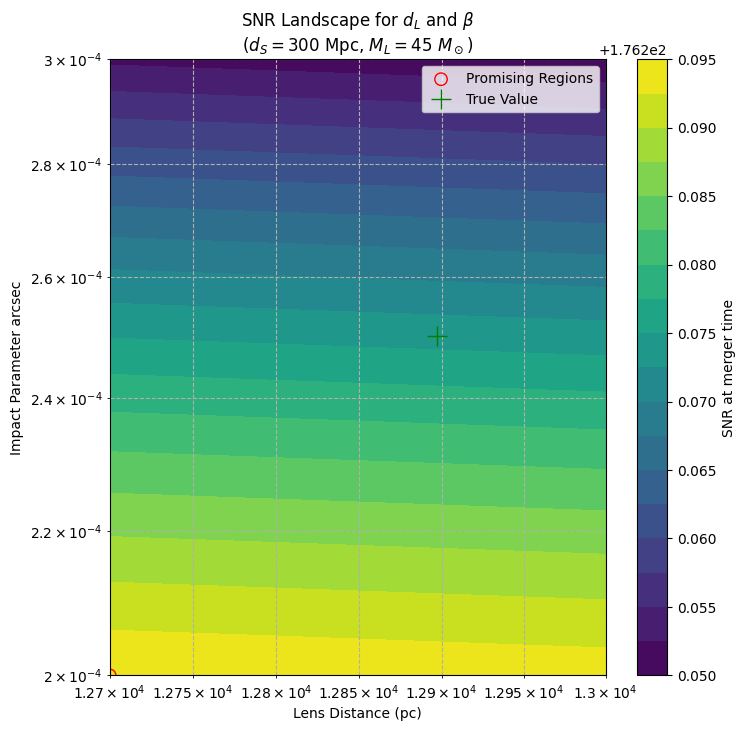

In [24]:
# PLOT THE 2D HEATMAPS WITH PROMISING POINTS OVERLAID ---

fig, ax = pylab.subplots(figsize=[8, 8])
'''
finite_mask = np.isfinite(max_snr_grid)
min_chi_squared = chi_squared_grid[finite_mask]
min_chi_squared = min_chi_squared.reshape(dl_grid.shape)
#delta_chi_squared = chi_squared_grid - min_chi_squared

#delta_chi_squared = chi_squared_grid - min_chi_squared

#delta_chi_squared_masked = np.ma.masked_invalid(min_chi_squared)
'''
# Plot
#vmin = delta_chi_squared_masked.min()
im2 = pylab.contourf(dl_grid , beta_grid ,max_snr_grid, levels=20, cmap = 'viridis')
fig.colorbar(im2, ax=ax, label='SNR at merger time')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Lens Distance (pc)')
ax.set_ylabel('Impact Parameter arcsec')
pylab.grid(True, which="both", ls="--")
title_str = (f'SNR Landscape for $d_L$ and $\\beta$\n'
             f'($d_S={fixed_ds_pc/1e6:.0f}$ Mpc, $M_L={fixed_lens_mass:.0f}$ $M_\\odot$)')
ax.set_title(title_str)


# Overlay the promising points on both plots
if len(promising_dl) > 0:

   ax.scatter(promising_dl , promising_beta ,
                facecolors='none', edgecolors='r', s=80, label='Promising Regions')
   ax.plot(true_dl_pc, true_beta_arcsec, 'g+', markersize=15, label='True Value')
   ax.legend()

pylab.show()

In [26]:
    #n_points = 20
    dl_pc_range = true_dl_pc
    beta_arcsec_range = true_beta_arcsec



    dl_grid, beta_grid = np.meshgrid(dl_pc_range, beta_arcsec_range, indexing='ij')





    params_list = list(zip(dl_grid.flatten(), beta_grid.flatten()))

    worker_func = partial(calculate_SNR_for_point,
                          fixed_mass_kg=fixed_mass_kg,
                          fixed_ds_m=fixed_ds_m,
                          hp_unlensed_freq_template=hp_unlensed_freq_template,
                          data_freq=data_freq,
                          #data=data,
                          new_psd=psd_data)
    

    #with multiprocessing.Pool(processes=18) as pool:
     #   results = list(tqdm(pool.imap(worker_func, params_list), total=len(params_list)))
    
    results = []
    for params in tqdm(params_list):
        result = worker_func(params)
        results.append(result)
    
    results = np.array(results)
    max_snr_grid = results.reshape(dl_grid.shape)
    print("Calculation complete.\n")

    # ---FILTER RESULTS TO FIND PROMISING PARAMETERS 

    max_snr = np.nanmax(max_snr_grid)
    print(f"Max SNR value found: {max_snr:.6f}")

    SNR_mask = max_snr_grid == max_snr
    promising_indices = np.where(SNR_mask)

    # d. Extract the dl and beta values from these promising points
    promising_dl = dl_grid[promising_indices]
    promising_beta = beta_grid[promising_indices]
    promising_SNR= max_snr_grid[promising_indices]



    print(f"Found {len(promising_dl)} promising parameter combinations.")

    if len(promising_dl) > 0:

        # Sort by SNR value to find the best candidates
        sort_indices = np.argsort(promising_SNR)[::-1]
        promising_dl = promising_dl[sort_indices]
        promising_beta = promising_beta[sort_indices]
        promising_SNR = promising_SNR[sort_indices]
        print("\nThese parameter sets can now be used to initialize MCMC walkers:")
        # We now have the dl and beta. The ds and mass were fixed.
        # We can create the full parameter set for MCMC.
        promising_ds = np.full_like(promising_dl, fixed_ds_pc)
        promising_mass = np.full_like(promising_dl, fixed_lens_mass)
        print("\nTop best parameter combinations:")
        for k in range(min(10, len(promising_dl))):
            print(f"  {k+1}. dl = {promising_dl[k]:.2f} pc, beta = {promising_beta[k]:.2e} arcsec, SNR = {promising_SNR[k]:.6f}")

100%|██████████| 1/1 [00:00<00:00,  9.05it/s]

Calculation complete.

Max SNR value found: 176.274051
Found 1 promising parameter combinations.

These parameter sets can now be used to initialize MCMC walkers:

Top best parameter combinations:
  1. dl = 12897.00 pc, beta = 2.50e-04 arcsec, SNR = 176.274051


With much more noise


Optimal SNR of the injected signal: 60.33

Simulated data created

Calculating true observables from injected parameters...
--- Setting up 2D Slice Analysis ---
Calculating chi-squared for 25 grid points using 18 cores...


100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Calculation complete.


--- Filtering Grid to Find Promising MCMC Starting Points ---
Max SNR value: 3.898948
Found 1 promising parameter combinations.

These parameter sets can now be used to initialize MCMC walkers:

Top 10 best parameter combinations:
  1. dl = 100000000.00 pc, beta = 2.50e-01 arcsec, chi² = 3.898948

Best point to start MCMC:
  dl   = 100000000.00 pc
  beta = 2.50e-01 arcsec
  ds   = 300 Mpc (fixed)
  M    = 45 M_sun (fixed)
  chi² = 3.898948


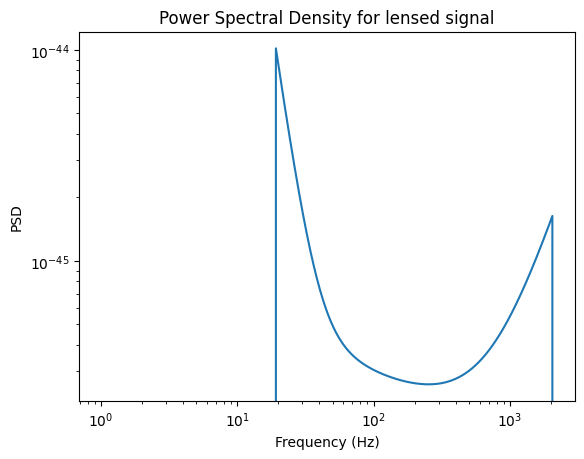

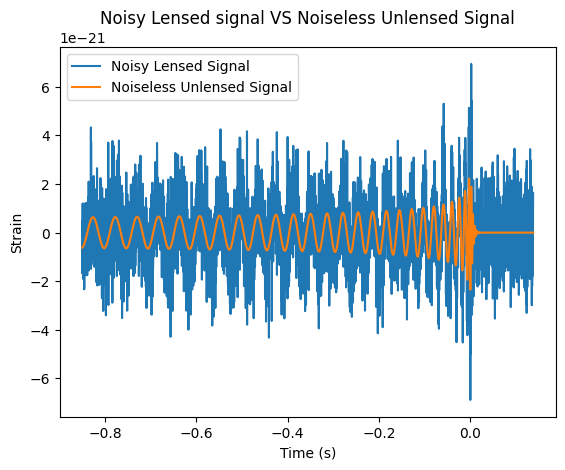

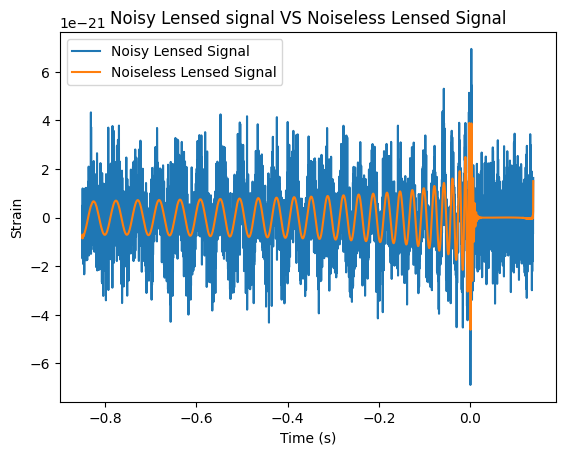

In [ ]:
if __name__ == "__main__":

    # ---1. First, we create our lensed data ---

    true_mass_lens = 45 #solar_masses
    true_dl_pc = 12897 #pc
    true_ds_pc = 300 #Mpc
    true_beta_arcsec = 2.5e-4

    hp_unlensed,_ = get_td_waveform(approximant='SEOBNRv3',
                             mass1=30,
                             mass2=30,
                             delta_t=1.0/4096,
                             f_lower=20,
                             distance = true_ds_pc)


    # 2. Calculate the amplification in the wave optic regime
    true_mass_lens_kg = true_mass_lens*solar_mass_kg #kg
    true_dl_m = (12897*u.pc).to(u.m).value #m
    true_ds_m = (300e6*u.pc).to(u.m).value #m
    true_beta_rad = (2.5e-4*u.arcsec).to(u.rad).value #rad

    hp_unlensed_freq = hp_unlensed.to_frequencyseries()
    frequency_array_template = np.array(hp_unlensed_freq.sample_frequencies)
    true_einstein_rad = einstein_radius_calc(true_mass_lens_kg,true_ds_m,true_dl_m)
    true_F_f = calculate_amplification_factor(frequency_array_template,true_mass_lens_kg,true_dl_m,true_beta_rad,true_einstein_rad)

    # 3. Apply the magnification
    hp_lensed_freq = hp_unlensed_freq * true_F_f
    hp_lensed = hp_lensed_freq.to_timeseries()
    hp_lensed = resample_to_delta_t(highpass(hp_lensed,10),1./4096)  #Warning, this induce artifacts at end end begininng but I don't think it is problematic as we'll focus at merger time
    hp_lensed.crop(0.1,0.1)

    # 4. Generate realistic noise
    delta_f = 1/hp_lensed.duration
    flen = len(hp_lensed)//2 + 1
    f_low = 20
    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low) * 20 #PSD ~ A**2
    freqs = psd.sample_frequencies
    psd_data = psd.data
    delta_t = 1.0 / 4096
    noise_len = len(hp_lensed)
    noise = pycbc.noise.noise_from_psd(noise_len, delta_t, psd, seed=150)
    noise_timeseries = TimeSeries(noise, delta_t= delta_t, epoch = hp_lensed.start_time) #bruit plotté à partir de t = 0 -> need a shift in h_plus

    # 5. Inject noise into the lensed signal. This is our data
    data = hp_lensed + noise_timeseries
    pylab.figure()
    pylab.loglog(freqs,psd)
    pylab.xlabel('Frequency (Hz)')
    pylab.ylabel('PSD')
    pylab.title('Power Spectral Density for lensed signal')
    pylab.figure()
    pylab.plot(data.sample_times,data, label = "Noisy Lensed Signal")
    pylab.plot(hp_unlensed.sample_times,hp_unlensed, label = "Noiseless Unlensed Signal")
    pylab.xlabel('Time (s)')
    pylab.ylabel('Strain')
    pylab.legend()
    pylab.title('Noisy Lensed signal VS Noiseless Unlensed Signal')
    pylab.figure()
    pylab.plot(data.sample_times,data, label = "Noisy Lensed Signal")
    pylab.plot(hp_lensed.sample_times,hp_lensed, label = "Noiseless Lensed Signal")
    pylab.xlabel('Time (s)')
    pylab.ylabel('Strain')
    pylab.legend()
    pylab.title('Noisy Lensed signal VS Noiseless Lensed Signal')



    psd_data = interpolate(psd,data.to_frequencyseries().delta_f)
    psd_data.resize(len(data))
    valid_indices = psd_data > 0
    delta_f = hp_lensed_freq.delta_f

    snr_series_best = matched_filter(data,data,psd=psd_data,low_frequency_cutoff=20,high_frequency_cutoff=1024)
    snr_array_best = np.array(snr_series_best)

    max_snr_best = np.max(np.abs(snr_array_best))

    print(f"\nOptimal SNR of the injected signal: {max_snr_best:.2f}\n")

    print ("Simulated data created\n")

    # --- 0. CALCULATE THE TRUE OBSERVABLES TO SEARCH FOR ---
    print("Calculating true observables from injected parameters...")
    # a. Define the fixed parameters
    fixed_ds_pc = true_ds_pc*1e6 # Source distance in Mpc
    fixed_lens_mass = true_mass_lens # Lens mass in Solar Masses



    # Get the noisy data in the frequency domain
    hp_unlensed_template = hp_unlensed.copy()
    hp_unlensed_template.resize(len(data))
    hp_unlensed_freq_template = hp_unlensed_template.to_frequencyseries()
    data_freq = data.to_frequencyseries()


    from pycbc.types import FrequencySeries
    hp_unlensed_freq_template = FrequencySeries(
        hp_unlensed_freq_template.data,
        delta_f=data_freq.delta_f,  # Force same delta_f for divison between frequency_series
        epoch=hp_unlensed_freq_template.epoch)

    #We can also do a noise weighted chisquared. It will be considered into the MCMC but this is not harmfull to already consider it
    #we need to resize the psd for this
    new_psd = interpolate(psd, data_freq.delta_f)
    new_psd.resize(len(data_freq))

    #We don't focus on the dt or group delay or magnification, we directly compare the F_f curves as it contains the amplification AND the phase


    # --- 1. SETUP THE 2D SLICE ANALYSIS ---

    print("--- Setting up 2D Slice Analysis ---")

    # b. Create the 2D grid for the parameters we want to vary
    n_points = 5
    dl_pc_range = np.linspace(1, 1e8, n_points) # 10 kpc to 10 Mpc
    beta_arcsec_range = np.linspace(1e-8, 1, n_points) # 0.01 to 1 milli-arcsec



    dl_grid, beta_grid = np.meshgrid(dl_pc_range, beta_arcsec_range, indexing='ij')



    # --- 2. PARALLEL CALCULATION OF THE GRID ---
    print(f"Calculating chi-squared for {n_points*n_points} grid points using 18 cores...")
    fixed_ds_m = (true_ds_pc * 1e6 * u.pc).to(u.m).value
    fixed_mass_kg = true_mass_lens * solar_mass_kg
    params_list = list(zip(dl_grid.flatten(), beta_grid.flatten()))

    worker_func = partial(calculate_chi_squared_for_point,
                          fixed_mass_kg=fixed_mass_kg,
                          fixed_ds_m=fixed_ds_m,
                          hp_unlensed_freq_template=hp_unlensed_freq_template,
                          data_freq=data_freq,
                          #data=data,
                          new_psd=new_psd)

    with multiprocessing.Pool(processes=18) as pool:
        results = list(tqdm(pool.imap(worker_func, params_list), total=len(params_list)))
    max_snr_grid = []
    for r in results:
      max = np.max(np.abs(r))
      max_snr_grid.append(max)


    max_snr_grid = np.array(max_snr_grid)
    max_snr_grid = max_snr_grid.reshape(dl_grid.shape)
    print("Calculation complete.\n")

    # --- 3. FILTER RESULTS TO FIND PROMISING PARAMETERS FOR MCMC ---
    print("\n--- Filtering Grid to Find Promising MCMC Starting Points ---")

    # a. Define chi_squared tolerance range

    #min_chi_squared = np.nanmin(chi_squared_grid)

    max_snr = np.nanmax(max_snr_grid)
    print(f"Max SNR value: {max_snr:.6f}")



    # b. Create masks to find where the grid values fall within the target ranges ==> We will have chi_squared~0
    SNR_mask = max_snr_grid == max_snr

    # c. Combine masks to find points that satisfy chi_squared condition
    promising_indices = np.where(SNR_mask)

    # d. Extract the dl and beta values from these promising points
    promising_dl = dl_grid[promising_indices]
    promising_beta = beta_grid[promising_indices]
    promising_SNR= max_snr_grid[promising_indices]



    print(f"Found {len(promising_dl)} promising parameter combinations.")

    if len(promising_dl) > 0:

        # Sort by chi-squared value to find the best candidates
        sort_indices = np.argsort(promising_SNR)[::-1]
        promising_dl = promising_dl[sort_indices]
        promising_beta = promising_beta[sort_indices]
        promising_SNR = promising_SNR[sort_indices]
        print("\nThese parameter sets can now be used to initialize MCMC walkers:")
        # We now have the dl and beta. The ds and mass were fixed.
        # We can create the full parameter set for MCMC.
        promising_ds = np.full_like(promising_dl, fixed_ds_pc)
        promising_mass = np.full_like(promising_dl, fixed_lens_mass)
        print("\nTop 10 best parameter combinations:")
        for k in range(min(10, len(promising_dl))):
            print(f"  {k+1}. dl = {promising_dl[k]:.2f} pc, beta = {promising_beta[k]:.2e} arcsec, chi² = {promising_SNR[k]:.6f}")

        print(f"\nBest point to start MCMC:")
        print(f"  dl   = {promising_dl[0]:.2f} pc")
        print(f"  beta = {promising_beta[0]:.2e} arcsec")
        print(f"  ds   = {fixed_ds_pc/1e6:.0f} Mpc (fixed)")
        print(f"  M    = {fixed_lens_mass:.0f} M_sun (fixed)")
        print(f"  chi² = {promising_SNR[0]:.6f}")


        '''

        #Extraction with promising set of parameters
        snr_extr = max_snr_grid[promising_indices]
        peak = np.argmax(abs(snr_extr))
        snrp = snr_series[peak]
        timepeak = snr_series.sample_times[peak]

        dt = timepeak - data.start_time
        aligned = h_lensed_template.cyclic_time_shift(dt)

        aligned /= sigma(aligned, psd=new_psd, low_frequency_cutoff = 15.0)
        aligned = (aligned.to_frequencyseries()*snrp).to_timeseries()
        aligned.start_time = data.start_time

        white_data = (data_freq/new_psd**0.5).to_timeseries()
        tapered = aligned.highpass_fir(30, 512, remove_corrupted=False)#filter

        white_template = (tapered.to_frequencyseries() / new_psd**0.5).to_timeseries()
        white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
        white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

        _,t = white_template.max_loc() #we localise the sample where the SNR is maximum (and so where we have the merger)
        '''


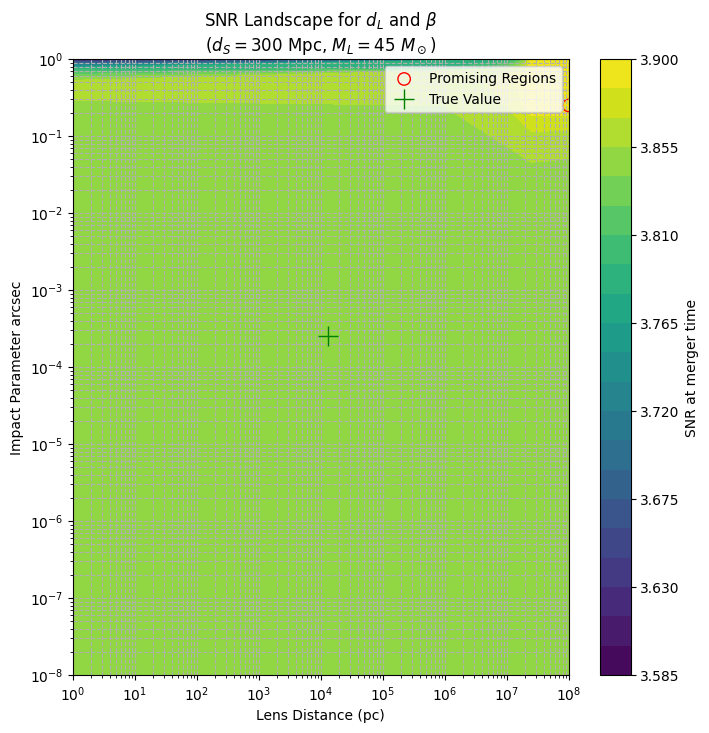

In [ ]:
# --- 4. PLOT THE 2D HEATMAPS WITH PROMISING POINTS OVERLAID ---

fig, ax = pylab.subplots(figsize=[8, 8])
'''
finite_mask = np.isfinite(max_snr_grid)
min_chi_squared = chi_squared_grid[finite_mask]
min_chi_squared = min_chi_squared.reshape(dl_grid.shape)
#delta_chi_squared = chi_squared_grid - min_chi_squared

#delta_chi_squared = chi_squared_grid - min_chi_squared

#delta_chi_squared_masked = np.ma.masked_invalid(min_chi_squared)
'''
# Plot
#vmin = delta_chi_squared_masked.min()
im2 = pylab.contourf(dl_grid , beta_grid ,max_snr_grid, levels=20, cmap = 'viridis')
fig.colorbar(im2, ax=ax, label='SNR at merger time')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Lens Distance (pc)')
ax.set_ylabel('Impact Parameter arcsec')
pylab.grid(True, which="both", ls="--")
title_str = (f'SNR Landscape for $d_L$ and $\\beta$\n'
             f'($d_S={fixed_ds_pc/1e6:.0f}$ Mpc, $M_L={fixed_lens_mass:.0f}$ $M_\\odot$)')
ax.set_title(title_str)


# Overlay the promising points on both plots
if len(promising_dl) > 0:

   ax.scatter(promising_dl , promising_beta ,
                facecolors='none', edgecolors='r', s=80, label='Promising Regions')
   ax.plot(true_dl_pc, true_beta_arcsec, 'g+', markersize=15, label='True Value')
   ax.legend()

pylab.show()